<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#LRP-gamma" data-toc-modified-id="LRP-gamma-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>LRP-gamma</a></span><ul class="toc-item"><li><span><a href="#Loading-the-trained-net-from-the-tutorial" data-toc-modified-id="Loading-the-trained-net-from-the-tutorial-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Loading the trained net from the tutorial</a></span></li><li><span><a href="#Implementing-LRP-gamma-and-DTD" data-toc-modified-id="Implementing-LRP-gamma-and-DTD-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Implementing LRP gamma and DTD</a></span></li><li><span><a href="#Transform-the-existing-model-to-an-instance-of-ExplainableModel" data-toc-modified-id="Transform-the-existing-model-to-an-instance-of-ExplainableModel-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Transform the existing model to an instance of <code>ExplainableModel</code></a></span></li><li><span><a href="#Plotting-the-Heatmaps" data-toc-modified-id="Plotting-the-Heatmaps-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plotting the Heatmaps</a></span></li><li><span><a href="#Layerwise-comparison-of-LRP-gamma=0-and-DTD" data-toc-modified-id="Layerwise-comparison-of-LRP-gamma=0-and-DTD-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Layerwise comparison of LRP gamma=0 and DTD</a></span></li><li><span><a href="#Effect-of-gamma" data-toc-modified-id="Effect-of-gamma-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Effect of gamma</a></span></li><li><span><a href="#Comparison-of-LRP-gamma=1-and-Gradient-Times-Input" data-toc-modified-id="Comparison-of-LRP-gamma=1-and-Gradient-Times-Input-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Comparison of LRP gamma=1 and Gradient Times Input</a></span></li><li><span><a href="#Usage-example:-direct-rebuilt-of-the-tutorial-net-as-explainable-net" data-toc-modified-id="Usage-example:-direct-rebuilt-of-the-tutorial-net-as-explainable-net-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Usage example: direct rebuilt of the tutorial net as explainable net</a></span></li></ul></li></ul></div>

# LRP-gamma

In this notebook, I try to implement LRP gamma without using gradients.

The advantage of not using gradients is, that it is possible to compute gradients of functions that depend on heatmaps. Since pytorch does not allow to compute gradients of gradients, it's the only way to do it.

`cifar10_utils.py` contains the net and dataloaders of the pytorch [cifar10 tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-download-beginner-blitz-cifar10-tutorial-py). Additionally, it contains `input_times_gradient(net, images, target_pattern)` and `plot_heatmaps(images, heatmaps)`. The idea is to analyze their trained network using LRP-gamma.

Let's prepare the implementation and load a trained network.

## Loading the trained net from the tutorial

In [1]:
%matplotlib inline
%load_ext autoreload

from cifar10_utils import *

Files already downloaded and verified
Files already downloaded and verified


In [2]:
net = Net()
net.load("cifar10net")
accuracy = net.accuracy(testloader)
print("Accuracy:", accuracy)

import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(net.class_accuracy(testloader))

Accuracy: 0.5268
{   'bird': 0.31690140845070425,
    'car': 0.7869674185463659,
    'cat': 0.2810126582278481,
    'deer': 0.33164556962025316,
    'dog': 0.5699208443271768,
    'frog': 0.517162471395881,
    'horse': 0.5382585751978892,
    'plane': 0.5869017632241813,
    'ship': 0.7306733167082294,
    'truck': 0.5280612244897959}


We will be dealing with different heatmapping techniques. The functions that generate them have the regular name, and objects that contain heatmaps will be called `h_<shortname>`.

## Implementing LRP gamma and DTD

Now, let's implement deeptaylor and LRP gamma.
We need the forward activations, so let's rewrite the network class a bit.

We want to add rules to layers that depend on their actications during the forwarding.
So we wrap the forwarding and create a number of `ExplainableLayer`s. Then we create a class for models that support deep taylor decompositions. `layerized_net.py` contains a layer and a network class that easily layerize any given pytorch model. We can add all the LRP functionality into some new `ExplainableLayer`s and an `ExplainableModel` and convert the pretrained net.

In [3]:
import torch.nn.functional as F
from torch import nn
import numpy as np
import copy
from layerized_net import Layer, LayerizedNet


na = None


class ExplainableLayer(Layer):
    """
    Base class for all layers that support deeptaylor
    """
    pass


class ReluLayer(ExplainableLayer, nn.Module):
    """
    Base class for layers that use Relus as nonlinearity.
    """
    def forward(self, x):
        self.x = x
        self.a = super().forward(x) # Super is called from a child class and via dependency injection this will be eg nn.Linear's forward layer 
        self.z = F.relu(self.a)
        return self.z
        
    
class Linear(ExplainableLayer, nn.Linear):
    """
    For linear layers without Relu activation, usually the last
    """
    def forward(self, x):
        D = np.prod(x.shape[1:])
        self.x = x
        x = x.view(-1, D)
        self.a = super().forward(x) # Super is called from a child class and via dependency injection this will be eg nn.Linear's forward layer 
        self.z = self.a
        return self.z
    
    def zplus(self, R, eps=1e-9):
        w_plus = F.relu(self.weight) # (D, d)
        z_plus = F.linear(self.x, w_plus, None)
        R_norm = R/(z_plus+eps) # (N, d)
        return F.linear(R_norm, w_plus.transpose(0, 1))*self.x
    
    def zb(self, R, l, h, eps=1e-9):
        w_plus  = F.relu(self.weight)
        w_minus = -F.relu(-self.weight)
        norm = self.z - l*F.linear(self.x, w_plus) - h*F.linear(self.x, w_minus)
        R_norm = R/norm
        return F.linear(R_norm, self.weight.transpose(0, 1))  \
            - l*F.linear(R_norm, self.w_plus.transpose(0, 1)) \
            - h*F.linear(R_norm, self.w_minus.transpose(0, 1))
    
    def lrp_gamma(self, R, gamma, bias_relevance=False):
        def leaky_relu(a):
            return F.relu(a) - gamma*F.relu(-a)
        w = leaky_relu(self.weight)
        b = leaky_relu(self.bias) if bias_relevance else None
        z = F.linear(self.x, w, b)
        R_norm = R/z
        return F.linear(R_norm, w.transpose(0, 1))*self.x
    


class LinearRelu(ReluLayer, Linear):
    """
    Combines the forwarding behaviour of ReluLayer with the
    relevance propagation rule of Linear
    """
    def forward(self, x):
        D = np.prod(x.shape[1:])
        return super().forward(x.view(-1, D))
    
    
class ConvRelu(ReluLayer, nn.Conv2d):
    """
    Implements deep taylor for conv2d layers
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_args = {
            'padding': self.padding,
            'stride': self.stride
        }
        
    def zplus(self, R, eps=1e-9):
        w_plus = F.relu(self.weight) # (D, d)
        z_plus = F.conv2d(self.x, w_plus, **self.conv_args)
        R_norm = R/(z_plus+eps) # (N, d)
        R_out_norm = F.conv_transpose2d(R_norm, w_plus, **self.conv_args)
        return R_out_norm*self.x
    
    def zb(self, R, l, h, eps=1e-9):
        w_plus  = F.relu(self.weight)
        w_minus = -F.relu(-self.weight)
        l = self.x*0 + l
        h = self.x*0 + h
        norm = F.conv2d(self.x, self.weight, **self.conv_args) \
            - F.conv2d(l, w_plus, **self.conv_args) \
            - F.conv2d(h, w_minus, **self.conv_args)
        R_norm = R/norm
        return self.x*F.conv_transpose2d(R_norm, self.weight, **self.conv_args)  \
            - l*F.conv_transpose2d(R_norm, w_plus, **self.conv_args) \
            - h*F.conv_transpose2d(R_norm, w_minus, **self.conv_args)
    
    def lrp_gamma(self, R, gamma, bias_relevance=False):
        def leaky_relu(a):
            return F.relu(a) - gamma*F.relu(-a)
        w = leaky_relu(self.weight)
        b = leaky_relu(self.bias) if bias_relevance else None
        z = F.conv2d(self.x, w, b, **self.conv_args)
        R_norm = R/z
        return F.conv_transpose2d(R_norm, w, **self.conv_args)*self.x
    
    def zb_gamma(self, R, l, h, gamma=0.9, bias_relevance=False):
        # I am not sure if the first layer's rule should be
        # the normal zB rule, but this is an interpolation of
        # the zB rule and input*gradient
        
        w_plus  = F.relu(self.weight)
        w_minus = -F.relu(-self.weight)
        l = self.x*0 + l
        h = self.x*0 + h
        norm = F.conv2d(self.x, self.weight, **self.conv_args) \
            - F.conv2d(l, w_plus, **self.conv_args)*(1-gamma) \
            - F.conv2d(h, w_minus, **self.conv_args)*(1-gamma)
        R_norm = R/norm
        return self.x*F.conv_transpose2d(R_norm, self.weight, **self.conv_args) \
            - l*F.conv_transpose2d(R_norm, w_plus, **self.conv_args)*(1-gamma) \
            - h*F.conv_transpose2d(R_norm, w_minus, **self.conv_args)*(1-gamma)
    
    @classmethod
    def from_module(cls, src):
        layer = copy.deepcopy(src)
        layer.__class__ = cls
        layer.conv_args = {
            'padding': layer.padding,
            'stride': layer.stride
        }
        return layer
    

class MaxPool(ReluLayer, nn.MaxPool2d):
    """
    Maxpool2d layer with the interface of the explainable ReluLayer
    """
    def __init__(self, *args, **kwargs):
        kwargs['return_indices'] = True
        super().__init__(*args, **kwargs)
        self._unpool = nn.MaxUnpool2d(kernel_size=self.kernel_size, stride=self.stride)
        
    def forward(self, x):
        self.x = x
        self.a, self.indices = nn.MaxPool2d.forward(self, x) 
        self.z = F.relu(self.a)
        return self.z
    
    def unpool(self, y):
        return self._unpool(y, self.indices, output_size=self.x.size())
    
    def zplus(self, R, *args, **kwargs):
        return self.unpool(R)
    
    def lrp_gamma(self, R, *args, **kwargs):
        return self.unpool(R)
    
    @staticmethod
    def from_module(src):
        return MaxPool(kernel_size=src.kernel_size,
                      stride=src.stride,
                      padding=src.padding,
                      dilation=src.dilation,
                      return_indices=True,
                      ceil_mode=src.ceil_mode
                      )
    
    
class ExplainableModel(LayerizedNet):
    """
    Base class for networks that implement deep taylor decomposition.
    Network architecture is not specified here
    
    Subclasses can do some of the following:
        - Add an architecture to `__init__`
        - Overwride `deeptaylor,` if the architecture and input domains require a
        different set of rules
        - Overwride `from_model` if the architecture requires it.
    """
    def __init__(self, layers, min_x=None, max_x=None):
        """
        Layers: Instances of subclasses of ReluLayer
        min_x, max_x: box constraints of the input domain, zB rule will be used there
            if not set, ww rule will be used in the first layer
        """
        super().__init__(layers)
        self.min_x, self.max_x = min_x, max_x
    
    def debug_info(self, layer, R, R_total):
        print(f"({layer.__class__.__name__}) ->", R.shape)
        print(f"({layer.__class__.__name__})     Conservation quotient: {R.sum()/R_total}")
        if R.min() < 0:
            print(f"({layer.__class__.__name__})     encountered negative values")
        print("")
    
    def deeptaylor(self, x, pattern, debug=False):
        """
        Deep Taylor Decomposition, where relevance is the outputlayer is predictions*pattern
        Pattern: eg one_hot(labels) if the heatmap for the correct class should be used
        """
        out = self.forward(x)
        R = F.relu(out*pattern)
        R_total = R.sum()
            
        for layer in self.layers[1:][::-1]:
            R = R.view(layer.z.shape)
            R = layer.zplus(R)
            if debug:
                self.debug_info(layer, R, R_total)
            
        # Select the input layer rule
        if self.min_x is None and self.max_x is None:
            R = self.layers[0].ww(R)
        elif self.min_x == 0 and self.max_x is None:
            R = self.layers[0].zplus(R)
        else:
            R = self.layers[0].zb(R, self.min_x, self.max_x)
            
        if debug:    
            self.debug_info(self.layers[0], R, R_total)
            
        return R
    
    def lrp_gamma(self, x, pattern, gamma=0.1, bias_relevance=False, debug=False):
        # Output layer relevance
        out = self.forward(x)
        R = out*pattern
        R_total = R.sum()
        
        # Backward pass
        for layer in self.layers[1:][::-1]:
            R = R.view(layer.z.shape)
            R = layer.lrp_gamma(R, gamma, bias_relevance=bias_relevance)
            if debug:
                self.debug_info(layer, R, R_total)
            
        # Input layer relevance depending on domain
        if self.min_x is None and self.max_x is None:
            R = self.layers[0].ww(R)
        elif self.min_x == 0 and self.max_x is None:
            R = self.layers[0].lrp_gamma(R, gamma)
        else:
            R = self.layers[0].zb_gamma(R, self.min_x, self.max_x, gamma=gamma)
            
        if debug:    
            self.debug_info(self.layers[0], R, R_total)
                
        return R 

## Transform the existing model to an instance of `ExplainableModel`

Let's check if the `from_model` works:

In [4]:
enet = ExplainableModel.from_model(
    model=net,
    layer_names=['conv1', 'pool', 'conv2', 'pool', 'fc1', 'fc2', 'fc3'],
    layer_base_type=ReluLayer, last_layer_type=Linear,
    min_x=-1, max_x=1)

accuracy = enet.accuracy(testloader)
print("Accuracy:", accuracy)

pp.pprint(net.class_accuracy(testloader))

# Also get some images and labels that are used in the cells below
dataiter = iter(testloader)
images, labels = dataiter.next()

Accuracy: 0.5268
{   'bird': 0.31690140845070425,
    'car': 0.7869674185463659,
    'cat': 0.2810126582278481,
    'deer': 0.33164556962025316,
    'dog': 0.5699208443271768,
    'frog': 0.517162471395881,
    'horse': 0.5382585751978892,
    'plane': 0.5869017632241813,
    'ship': 0.7306733167082294,
    'truck': 0.5280612244897959}


Great!

Now, let's alsp generate some heatmaps

## Plotting the Heatmaps

--------------------
   Deep Taylor Decomposition
(5, 3, 32, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


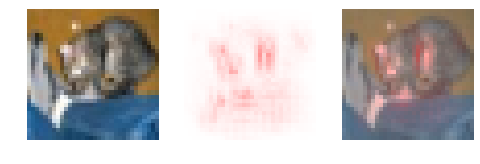

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


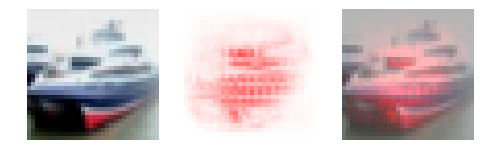

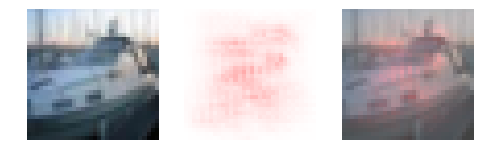

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


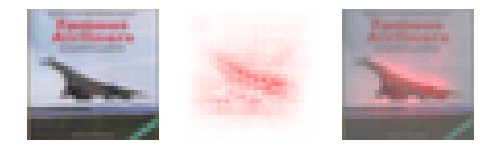

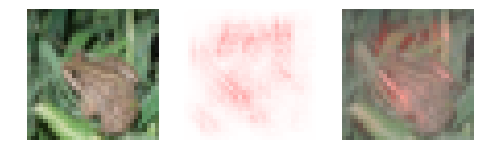

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------
   LRP-gamma 0.5
(5, 3, 32, 32)


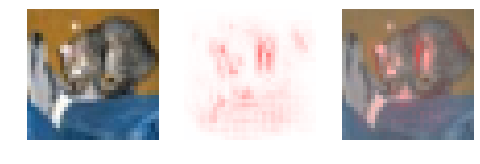

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


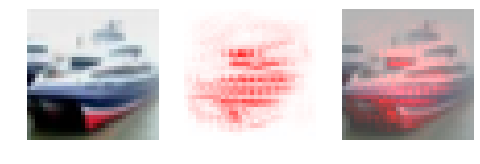

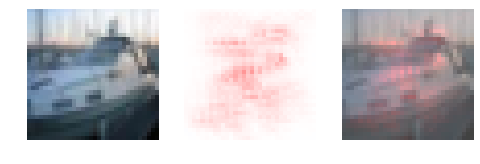

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


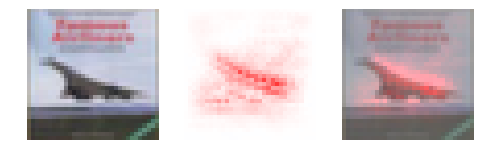

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


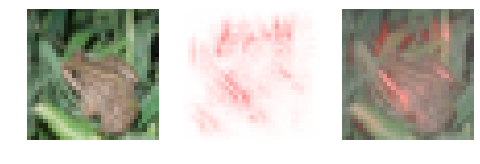

In [5]:
print("--------------------")
print("   Deep Taylor Decomposition")
h_dtd = enet.deeptaylor(images[:5], one_hot(labels[:5]))
plot_heatmaps(images[:5], h_dtd.sum(1)*8)

print("--------------------")
print("   LRP-gamma 0.5")
h_gamma = enet.lrp_gamma(images[:5], one_hot(labels[:5]), gamma=0.5)
plot_heatmaps(images[:5], h_gamma.sum(1)*8)

## Layerwise comparison of LRP gamma=0 and DTD
We can test that LRP gamma with gamma=0 is equal to the deep taylor decomposition

In [6]:
# DEBUG
self = enet
x = images
pattern = one_hot(labels)
gamma = 0

out = self.forward(x)
R = out*pattern
R_total = R.sum()

R_g = R
R_d = R
# Backward pass
for layer in self.layers[1:][::-1]:
    R_g = R_g.view(layer.z.shape)
    R_g = layer.lrp_gamma(R_g, gamma)
    
    R_d = R_d.view(layer.z.shape)
    R_d = layer.zplus(R_d, gamma)
    
    print(f"{layer.__class__.__name__} Max relative error: {((R_g-R_d)/(R_d+1e-7)).abs().max()}")

R_g = self.layers[0].zb_gamma(R_g, self.min_x, self.max_x, gamma=gamma)
R_d = self.layers[0].zb_gamma(R_d, self.min_x, self.max_x, gamma=gamma)    
print(f"{self.layers[0].__class__.__name__} Max relative error: {((R_g-R_d)/(R_d+1e-7)).abs().max()}")

lrp_gamma = enet.lrp_gamma(images, pattern, 0).detach()
deeptaylor = enet.deeptaylor(images, pattern).detach()
assert np.allclose(R_g.detach(), lrp_gamma), "R_g is wrong"
assert np.allclose(R_d.detach(), deeptaylor), "R_d is wrong"
assert np.allclose(lrp_gamma, deeptaylor), "R_d != R_g"

Linear Max relative error: 0.0
LinearRelu Max relative error: 0.0
LinearRelu Max relative error: 0.0
MaxPool Max relative error: 0.0
ConvRelu Max relative error: 0.0
MaxPool Max relative error: 0.0
ConvRelu Max relative error: 0.0


## Effect of gamma

Let's compare heatmaps depending on their gamma value

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



LRP-gamma 0.0
(1, 3, 32, 32)


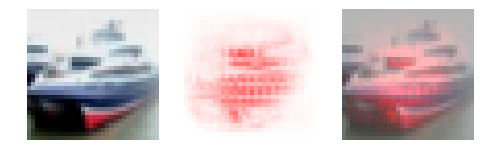

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



LRP-gamma 0.1
(1, 3, 32, 32)


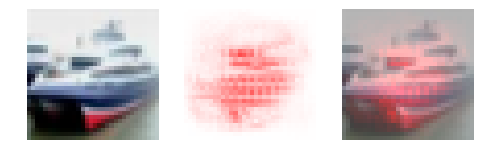

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



LRP-gamma 0.2
(1, 3, 32, 32)


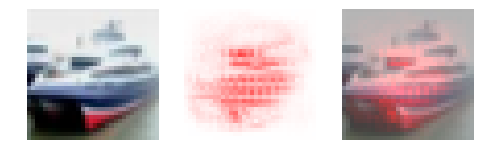

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



LRP-gamma 0.30000000000000004
(1, 3, 32, 32)


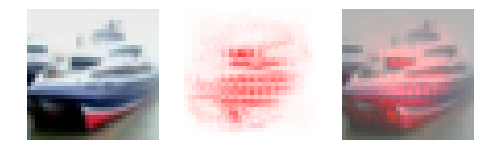


LRP-gamma 0.4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)


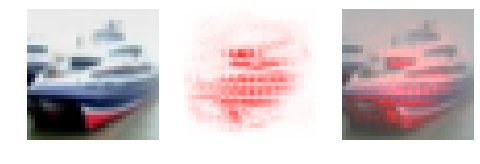

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



LRP-gamma 0.5
(1, 3, 32, 32)


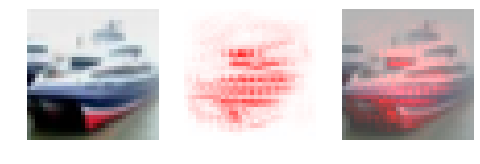

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



LRP-gamma 0.6000000000000001
(1, 3, 32, 32)


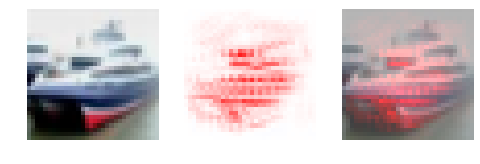

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



LRP-gamma 0.7000000000000001
(1, 3, 32, 32)


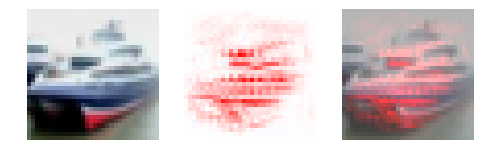

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



LRP-gamma 0.8
(1, 3, 32, 32)


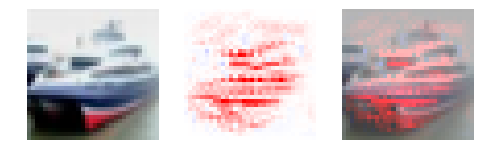


LRP-gamma 0.9
(1, 3, 32, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


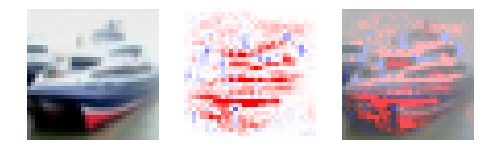


LRP-gamma 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 32, 32)


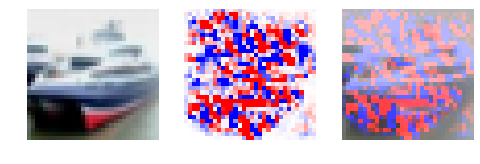

In [8]:
image, label = images[1][na], labels[1][na]
heatmaps = []
for gamma in np.arange(0,1.1,0.1):
    print("\n=============")
    print(f"LRP-gamma {gamma}")
    h = enet.lrp_gamma(image, one_hot(label), gamma).detach()
    plot_heatmaps(image, h.sum(1)*8)



## Comparison of LRP gamma=1 and Gradient Times Input

In [9]:
# Check if LRP-gamma 0 == deep taylor
if np.allclose(
        enet.lrp_gamma(images, one_hot(labels), 0).detach(),
        enet.deeptaylor(images, one_hot(labels)).detach()):
    print("Deep Taylor == LRP gamma 0")
else:
    print("Deep Taylor == LRP gamma 0")

if np.allclose(
        enet.lrp_gamma(images, one_hot(labels), 1).detach(),
        input_times_gradient(enet, images, one_hot(labels)).detach()):
    print("Input times Gradient == LRP gamma 1")
else:
    print("Input times Gradient != LRP gamma 1")


Deep Taylor == LRP gamma 0
Input times Gradient != LRP gamma 1


/Users/nielswarncke/Documents/pytorch-tuts/cifar10_experiments/trainable_net.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(images, requires_grad=True)


I think LRP-1 is equal to LRP-epsilon, which I haven't implemented here. LRP-epsilon is like input times gradient, but for every neuron, it is normalized such that it is conservative. The connection is explained nicely [here](https://arxiv.org/abs/1711.06104).

## Usage example: direct rebuilt of the tutorial net as explainable net

And here is an example how to rebuild Net directly:

[1,  2000] loss: 2.298
[1,  4000] loss: 2.085
Accuracy: 0.3522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10, 3, 32, 32)


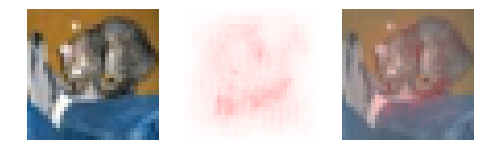

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


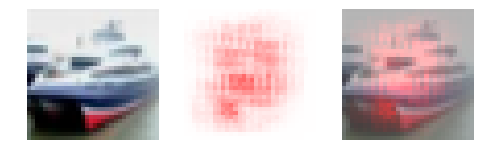

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


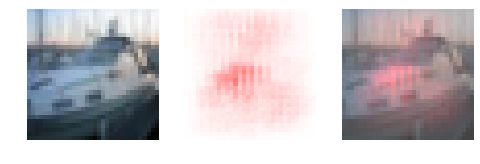

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


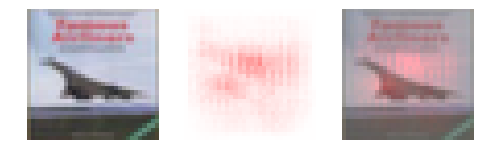

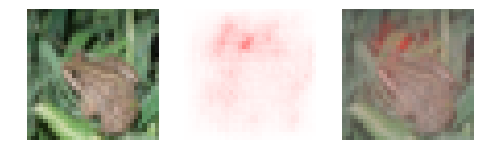

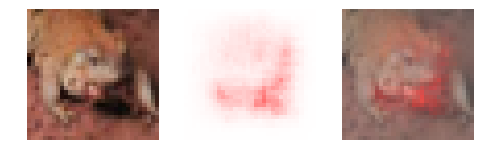

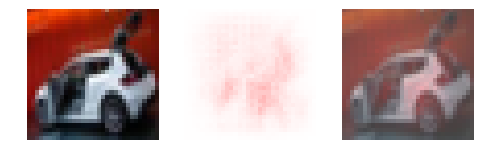

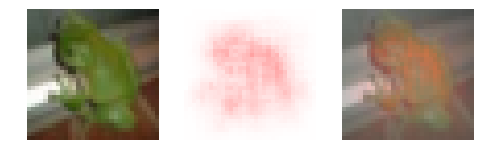

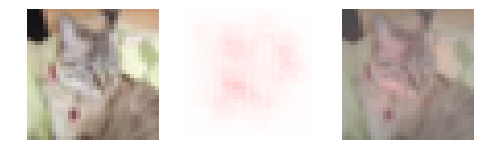

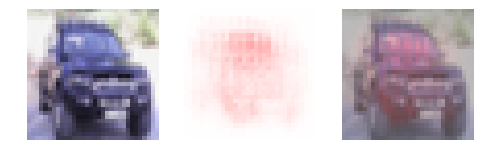

In [10]:
class ExplainNet(ExplainableModel):
    """
    Rebuilt of cifar10utils.Net with deep taylor support
    """
    def __init__(self):
        layers = [
            ConvRelu(3, 6, 5),
            MaxPool(2, 2),
            ConvRelu(6, 16, 5),
            MaxPool(2, 2),
            LinearRelu(16 * 5 * 5, 120),
            LinearRelu(120, 84),
            LinearRelu(84, 10)
        ]
        super().__init__(layers, -1, 1)
        
        # Because pytorch is weird, the submodels cannot be stored in a list
        self.l1 = layers[0]
        self.l2 = layers[1]
        self.l3 = layers[2]
        self.l4 = layers[3]
        self.l5 = layers[4]
        self.l6 = layers[5]
            
        

enet_sister = ExplainNet()
enet_sister.train(1, trainloader)

accuracy = enet_sister.accuracy(testloader)
print("Accuracy:", accuracy)

dataiter = iter(testloader)
images, labels = dataiter.next()
h_dtd = enet_sister.deeptaylor(images, one_hot(labels))
plot_heatmaps(images, h_dtd.sum(1)*10)

It is trained for only one epoch, and the heatmaps look rather blurry. 